In [93]:
# import libraries
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import display
from time import gmtime, strftime
from sagemaker.predictor import csv_serializer

# Define IAM role
role = get_execution_role()
prefix = 'sagemaker/DEMO-xgboost-dm'
my_region = boto3.session.Session().region_name # set the region of the instance

# this line automatically looks for the XGBoost image URI and builds an XGBoost container.
xgboost_container = sagemaker.image_uris.retrieve("xgboost", my_region, "latest")


print("Success - the MySageMakerInstance is in the " + my_region + " region. You will use the " + xgboost_container + " container for your SageMaker endpoint.")

bucket_name = 'weatherme' # <--- CHANGE THIS VARIABLE TO A UNIQUE NAME FOR YOUR BUCKET
s3 = boto3.resource('s3')

Success - the MySageMakerInstance is in the ap-south-1 region. You will use the 991648021394.dkr.ecr.ap-south-1.amazonaws.com/xgboost:latest container for your SageMaker endpoint.


In [94]:
# !pip install xgboost
# !pip install pandas_profiling
# !conda list matplotlib
# !pip install matplotlib
!pip install kneed


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip


In [95]:
import numpy as np
import pandas as pd
from scipy.stats import skew
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import warnings
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import pickle
import os
import shutil
warnings.filterwarnings("ignore") 

In [146]:
data = pd.read_csv("output_file.csv",na_values="?")
data.head()


,time,Wind_speed,Wind_dir,Visibility,Temperature,dewpoint,Humidity
0,2021-11-01 00:00,2.100013,207.79967,21544.232,288.35187,278.53552,88.662880
1,2021-11-01 00:20,1.494543,195.41899,22789.700,289.25757,278.40363,85.743430
2,2021-11-01 00:40,1.203924,205.38362,26924.135,293.32623,278.90930,66.800240
3,2021-11-01 01:00,0.787564,204.74925,28133.807,297.54370,279.38147,53.934402
4,2021-11-01 01:20,1.840468,187.68733,29133.484,300.45508,278.62110,36.173420


In [97]:
#unit conversion

for ind in data.index:
    data['Temperature'][ind] = data['Temperature'][ind]- 273.15
    

In [98]:
data.describe()
data.head()

,time,Wind_speed,Wind_dir,Visibility,Temperature,dewpoint,Humidity
0,2021-11-01 00:00,2.100013,207.79967,21544.232,15.20187,278.53552,88.662880
1,2021-11-01 00:20,1.494543,195.41899,22789.700,16.10757,278.40363,85.743430
2,2021-11-01 00:40,1.203924,205.38362,26924.135,20.17623,278.90930,66.800240
3,2021-11-01 01:00,0.787564,204.74925,28133.807,24.39370,279.38147,53.934402
4,2021-11-01 01:20,1.840468,187.68733,29133.484,27.30508,278.62110,36.173420


Check to see and impute any null values

In [99]:
data.isnull().sum()


time           0
Wind_speed     0
Wind_dir       0
Visibility     0
Temperature    0
dewpoint       0
Humidity       0
dtype: int64

EDA Analysis

In [100]:
!pip install matplotlib==3.1.3
import pandas_profiling
pandas_profiling.ProfileReport(data, minimal=True)


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [147]:
data['time']=pd.to_datetime(data['time']  ,format='%Y-%m-%d %H:%M')

Before Analyzing furthur lets scale our data and divide it into Target and Data accordingly

In [101]:
scale = StandardScaler()
X = data.drop(['time','Visibility'],axis=1)
y = data['Visibility']

In [102]:
X_scaled = scale.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled,columns=X.columns)

In [103]:
X_scaled

,Wind_speed,Wind_dir,Temperature,dewpoint,Humidity
0,-0.324032,-0.130217,-0.065281,-0.277136,0.777054
1,-0.885899,-0.270534,0.098113,-0.327082,0.653299
2,-1.155589,-0.157599,0.832125,-0.135586,-0.149699
3,-1.541965,-0.164789,1.592983,0.043223,-0.695078
4,-0.564887,-0.358161,2.118214,-0.244727,-1.447962
...,...,...,...,...,...
8634,0.398463,-1.994801,-0.073363,0.766826,0.349763
8635,0.445471,-1.831891,-0.154811,0.398831,0.450414
8636,0.335459,-1.656748,-0.251794,0.118254,0.522131
8637,-1.522696,-0.795249,-0.361766,-0.370000,0.942603


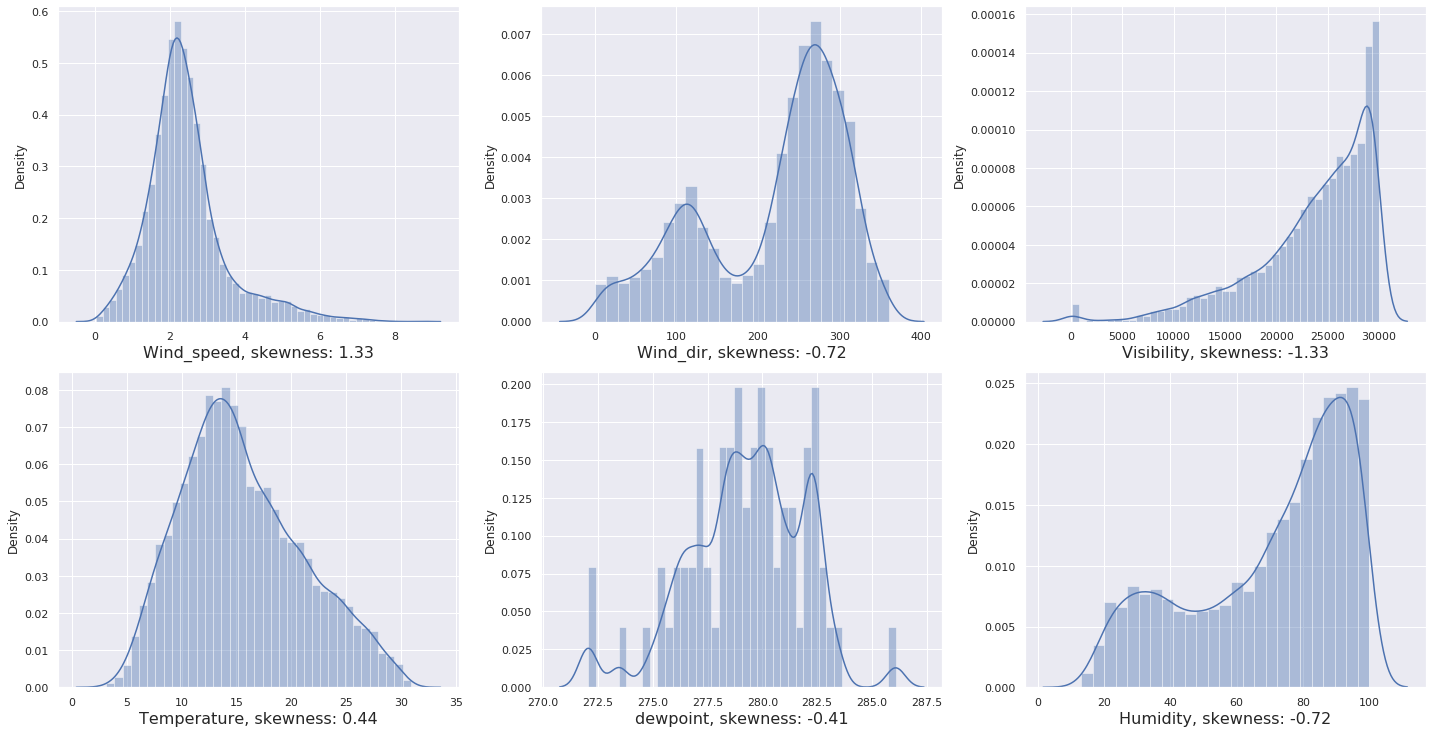

In [104]:
sns.set()
%matplotlib inline
plt.figure(figsize=(20,25), facecolor='white')
plotnumber = 1

for column in data.drop(['time'],axis=1):
    ax = plt.subplot(5,3,plotnumber)
    sns.distplot(data[column])
    s = round(skew(data[column]), 2) 
    plt.xlabel("{}, skewness: {}".format(column, s),fontsize=16)
    plotnumber+=1
plt.tight_layout()
plt.show()
plt.

Since some of the columns are not following normal distribution curve, We will try to use either square root or log transformations. But since most of the columns have very low skewness, its better to remove columns like precipitation. But before that lets analyze the correlation matrix

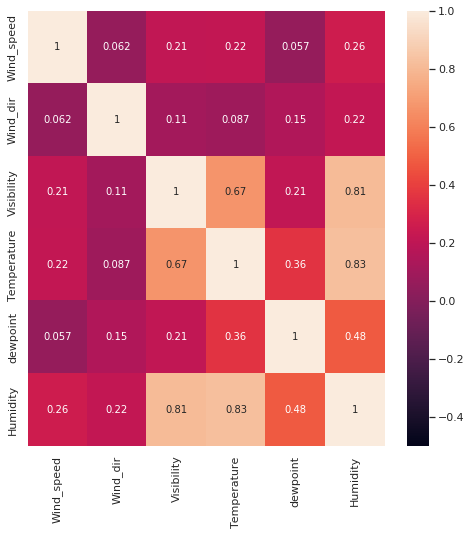

In [105]:
plt.figure(figsize=(8,8))
plt_data = data.drop(['time'],axis=1)
sns.heatmap(plt_data.corr().abs(), vmin = -0.5,vmax = 1,annot=True)

From the correlation heatmap, we can see that our target variable has a decent correlation with Hourly Precipitation, so lets leave it like that. But it can also be seen that there is a clear correlation between some other columns, so lets remove them

In [106]:
# X_ = X_scaled.drop(['surface_pre','sea_level_pre',],axis=1)
X_ = X_scaled

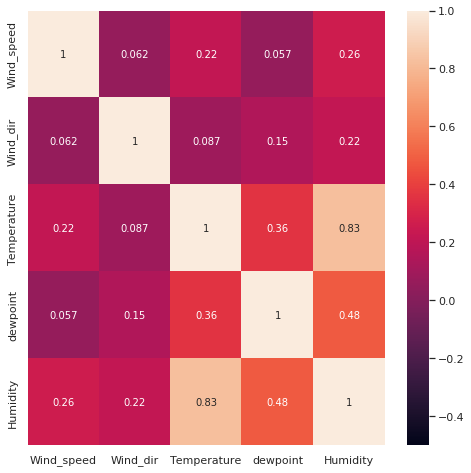

In [107]:
plt.figure(figsize=(8,8))
plt_data = X_
sns.heatmap(plt_data.corr().abs(), vmin = -0.5,vmax = 1,annot=True)

Still some columns have a high correlation, So lets also remove columns in a way that the correlations minimizes

In [108]:
# X_ = X_.drop(['precipitation','Cloud','Fog'],axis=1)
# X_

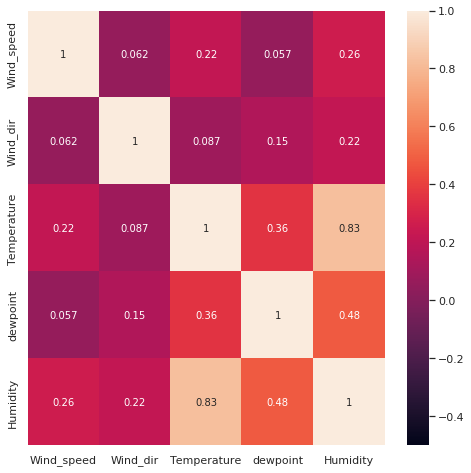

In [109]:
plt.figure(figsize=(8,8))
plt_data = X_
sns.heatmap(plt_data.corr().abs(), vmin = -0.5,vmax = 1,annot=True)

Now our correlation graph is perfect, lets now move to creating various regression models

In [110]:
x_train, x_test, y_train, y_test = train_test_split(X_, y, train_size=0.8, shuffle=False)

In [111]:
X1 = X_[:]
X1["Visibility"] = y
X1

,Wind_speed,Wind_dir,Temperature,dewpoint,Humidity,Visibility
0,-0.324032,-0.130217,-0.065281,-0.277136,0.777054,21544.232
1,-0.885899,-0.270534,0.098113,-0.327082,0.653299,22789.700
2,-1.155589,-0.157599,0.832125,-0.135586,-0.149699,26924.135
3,-1.541965,-0.164789,1.592983,0.043223,-0.695078,28133.807
4,-0.564887,-0.358161,2.118214,-0.244727,-1.447962,29133.484
...,...,...,...,...,...,...
8634,0.398463,-1.994801,-0.073363,0.766826,0.349763,24983.137
8635,0.445471,-1.831891,-0.154811,0.398831,0.450414,24396.059
8636,0.335459,-1.656748,-0.251794,0.118254,0.522131,23917.078
8637,-1.522696,-0.795249,-0.361766,-0.370000,0.942603,18756.250


Linear Regression

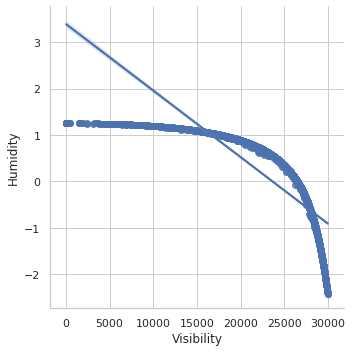

In [112]:
regr = LinearRegression()
regr.fit(x_train, y_train)
y_pred = regr.predict(x_test)
mse = mean_squared_error(y_test,y_pred)

sns.set_style('whitegrid')
sns.lmplot(x ='Visibility', y ='Humidity', data = X1)

# r2 = r2_score(y_test,y_pred)
# print(f"\nR2 Score: {r2}")
# sns.pairplot(X1, x_vars=["Fog","Temperature","Cloud","Humidity","Wind_dir","Wind_speed","precipitation"], y_vars = "Visibility", size = 9, aspect = 0.7, kind = "reg" )

Polynomial Regression

In [113]:
poly = PolynomialFeatures()
X_poly = poly.fit_transform(x_train)
poly.fit(x_train,y_train)
model = LinearRegression()
model.fit(X_poly, y_train)
y_pred = model.predict(poly.fit_transform(x_test))

# plt.figure(figsize=(10, 6))
# plt.title("Polynomial Regression", size=16)
# plt.scatter(x_test["Fog"], y_test)
# plt.plot(x_test, y_pred, c="red")
# plt.show()

r2 = r2_score(y_test,y_pred)
print(f"\nR2 Score: {r2}")


R2 Score: 0.8624533988517831


Decision Tree Regressor

Using Grid Search to find best parameters for Decision Tree Regressor

In [114]:
def get_best_params_for_DecisionTreeRegressor(train_x, train_y):
    try:
        DecisionTreeReg = DecisionTreeRegressor()
        param_grid_decisionTree = {"criterion": ["mse", "friedman_mse", "mae"],
                          "splitter": ["best", "random"],
                          "max_features": ["auto", "sqrt", "log2"],
                          'max_depth': range(2, 16, 2),
                          'min_samples_split': range(2, 16, 2)
                          }
        grid = GridSearchCV(DecisionTreeReg, param_grid_decisionTree, verbose=3,cv=2)
        grid.fit(train_x, train_y)

        criterion = grid.best_params_['criterion']
        splitter = grid.best_params_['splitter']
        max_features = grid.best_params_['max_features']
        max_depth  = grid.best_params_['max_depth']
        min_samples_split = grid.best_params_['min_samples_split']

        return criterion, splitter, max_features, max_depth, min_samples_split
    except Exception as e:
      print(e)

In [115]:
criterion, splitter, max_features, max_depth, min_samples_split = get_best_params_for_DecisionTreeRegressor(x_train, y_train)

Fitting 2 folds for each of 882 candidates, totalling 1764 fits
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_split=2, splitter=best 
[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_split=2, splitter=best, score=0.863, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_split=2, splitter=best 
[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_split=2, splitter=best, score=0.835, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_split=2, splitter=random 
[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_split=2, splitter=random, score=0.519, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_split=2, splitter=random 
[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_split=2, splitter=random, score=0.105, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_split=4, splitter=best 
[CV]  criterion=mse, max

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_split=10, splitter=best, score=0.062, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_split=10, splitter=random 
[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_split=10, splitter=random, score=0.143, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_split=10, splitter=random 
[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_split=10, splitter=random, score=0.240, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_split=12, splitter=best 
[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_split=12, splitter=best, score=0.786, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_split=12, splitter=best 
[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_split=12, splitter=best, score=0.059, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt,

[Parallel(n_jobs=1)]: Done 1764 out of 1764 | elapsed:  1.4min finished


In [116]:
# criterion, splitter, max_features, max_depth, min_samples_split
print("Best Criterion: ", criterion)
print("Best Splitter: ", splitter)
print("Best number of features: ", max_features)
print("Best Depth: ", max_depth)
print("Best Min Sample Split: ", min_samples_split)

Best Criterion:  mae
Best Splitter:  best
Best number of features:  auto
Best Depth:  8
Best Min Sample Split:  6


In [117]:
decisionTreeReg = DecisionTreeRegressor(criterion="friedman_mse",splitter="best",max_features="auto",max_depth=8,min_samples_split=2)
decisionTreeReg.fit(x_train, y_train)
y_pred = decisionTreeReg.predict(x_test)
r2 = r2_score(y_test,y_pred)
print(f"\nR2 Score: {r2}")


R2 Score: 0.9997014908662857


Support Vector Machines

In [118]:
from sklearn import svm
list_kernel = ["linear", "rbf"]
for kern in list_kernel:
  print("Kernel :", kern)
  clf = svm.SVR(kernel=kern)
  y_pred = clf.fit(x_train, y_train).predict(x_test)
  mse = np.mean((clf.predict(x_test) - y_test) ** 2)
  print("Mean squared error: %.2f" % np.mean((clf.predict(x_test) - y_test) ** 2))
  r2 = r2_score(y_test,y_pred)
  print(f"\nR2 Score: {r2}")
  print('Variance score: %.2f' % clf.score(x_test, y_test))
  # print()

Kernel : linear
Mean squared error: 10391843.87

R2 Score: 0.5780072571062996
Variance score: 0.58
Kernel : rbf
Mean squared error: 20246473.36

R2 Score: 0.1778297543905596
Variance score: 0.18


XG Boost

Using GridSearch to find best parameters for XGBoost

In [119]:
def get_best_params_for_xgboost(train_x,train_y):
    try:
        param_grid_xgboost = {

            'learning_rate': [0.5, 0.1, 0.01, 0.001],
            'max_depth': [3, 5, 10, 20],
            'n_estimators': [10, 50, 100, 200]

        }
        grid= GridSearchCV(XGBRegressor(objective='reg:linear'),param_grid_xgboost, verbose=3,cv=5)
        grid.fit(train_x, train_y)
        learning_rate = grid.best_params_['learning_rate']
        max_depth = grid.best_params_['max_depth']
        n_estimators = grid.best_params_['n_estimators']

        return learning_rate, max_depth, n_estimators
    except Exception as e:
      print(e)

In [120]:
learning_rate, max_depth, n_estimators = get_best_params_for_xgboost(x_train,y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] learning_rate=0.5, max_depth=3, n_estimators=10 .................
[22:17:01] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.5, max_depth=3, n_estimators=10, score=0.998, total=   0.1s
[CV] learning_rate=0.5, max_depth=3, n_estimators=10 .................
[22:17:01] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  learning_rate=0.5, max_depth=3, n_estimators=10, score=0.997, total=   0.1s
[CV] learning_rate=0.5, max_depth=3, n_estimators=10 .................
[22:17:02] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.5, max_depth=3, n_estimators=10, score=0.998, total=   0.1s
[CV] learning_rate=0.5, max_depth=3, n_estimators=10 .................
[22:17:02] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.5, max_depth=3, n_estimators=10, score=0.998, total=   0.1s
[CV] learning_rate=0.5, max_depth=3, n_estimators=10 .................
[22:17:02] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV]  learning_rate=0.5, max_depth=3, n_estimators=10, score=0.998, total=   0.1s
[CV] learning_rate=0.5, max_depth=3, n_estimators=50 .................
[22:17:02] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.5, max_depth=3, n_estimators=50, score=0.999, total=   0.3s
[CV] learning_rate=0.5, max_depth=3, n_estimators=50 .................
[22:17:02] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.5, max_depth=3, n_estimators=50, score=0.999, total=   0.3s
[CV] learning_rate=0.5, max_depth=3, n_estimators=50 .................
[22:17:02] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.5, max_depth=3, n_estimators=50, score=1.000, total=   0.3s
[CV] learning_rate=0.5, max_depth=3, n_estimators=50 .................
[22:17:03] WARNING: ../src/obje

KeyboardInterrupt: 

In [ ]:
print("Best Learning Rate: ", learning_rate)
print("Best Max Depth: ", max_depth)
print("Best N Estimators: ", n_estimators)

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', learning_rate = 0.1,
                max_depth = 5, n_estimators = 100)
xg_reg.fit(x_train,y_train)
y_pred = xg_reg.predict(x_test)
print(y_pred)
r2 = r2_score(y_test,y_pred)
print(f"\nR2 Score: {r2}")

Since for individual models we are not getting significant errors in the predicted values. We decided to change our approach from single model to a multimodel approach.

This will be done by first using K-Means clustering to divide the dataset into mutiple clusters and then using separate models for each cluster

In [121]:
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn import svm


Finding Knee of the Cluster for optimal number of clusters

In [122]:
x_train, x_test, y_train, y_test = train_test_split(X_, y, train_size=0.7)

In [123]:
def elbow_plot(data):
    wcss=[] #within-clusters-sum-of-squares
    try:
        for i in range (1,11):
            kmeans=KMeans(n_clusters=i,init='k-means++',random_state=42)
            kmeans.fit(data)
            wcss.append(kmeans.inertia_)
        plt.plot(range(1,11),wcss)
        plt.title('The Elbow Method')
        plt.xlabel('Number of clusters')
        plt.ylabel('WCSS')
        plt.show()
        
        kn = KneeLocator(range(1, 11), wcss, curve='convex', direction='decreasing')
        print('The optimum number of clusters is: '+ str(kn.knee))
        return kn.knee

    except Exception as e:
        print(e)

In [124]:
model_directory='models/'
def save_model_(model,filename):
    try:
        path = os.path.join(model_directory,filename)
        if os.path.isdir(path):
            shutil.rmtree(model_directory)
            os.makedirs(path)
        else:
            os.makedirs(path)
        with open(path +'/' + filename+'.sav',
                  'wb') as f:
            pickle.dump(model, f)
        return 'success'
    except Exception as e:
        print(e)

In [125]:
def create_clusters(data,number_of_clusters):
    data=data
    try:
        kmeans = KMeans(n_clusters=number_of_clusters, init='k-means++', random_state=42)
        y_kmeans=kmeans.fit_predict(data)
        save_model = save_model_(kmeans, 'KMeans') # saving the KMeans model to directory
                                                                                # passing 'Model' as the functions need three parameters
        data['Cluster']=y_kmeans  # create a new column in dataset for storing the cluster information
        return data
    except Exception as e:
        print(exec)

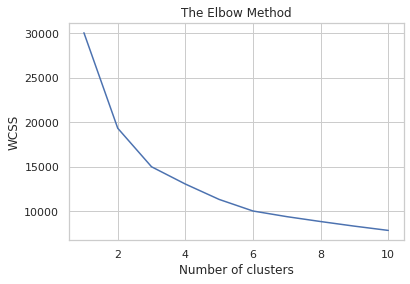

The optimum number of clusters is: 3


In [126]:
number_of_clusters=elbow_plot(x_train)  #  using the elbow plot to find the number of optimum clusters

In [127]:
x_train

,Wind_speed,Wind_dir,Temperature,dewpoint,Humidity
2521,-1.039256,0.500733,-0.268525,-0.327082,1.217609
202,0.181162,0.332921,2.158041,2.580152,-1.432531
1280,0.133785,0.470727,0.974687,-1.078315,-0.941338
1592,1.386858,0.473532,1.976451,-2.727362,-2.035960
8253,0.508676,-2.042368,-0.097677,0.316381,0.798936
...,...,...,...,...,...
738,0.465123,0.378551,0.089105,0.147315,0.613613
492,-0.065584,0.580663,1.134910,1.265608,-0.191685
1835,-2.155044,-1.366598,1.183958,1.113879,0.535625
1874,-0.887823,-1.436922,-0.018347,-0.135586,0.568878


In [128]:
# Divide the data into clusters
new_data = x_train[:]
new_data=create_clusters(x_train, number_of_clusters)
new_data

,Wind_speed,Wind_dir,Temperature,dewpoint,Humidity,Cluster
2521,-1.039256,0.500733,-0.268525,-0.327082,1.217609,0
202,0.181162,0.332921,2.158041,2.580152,-1.432531,1
1280,0.133785,0.470727,0.974687,-1.078315,-0.941338,1
1592,1.386858,0.473532,1.976451,-2.727362,-2.035960,1
8253,0.508676,-2.042368,-0.097677,0.316381,0.798936,2
...,...,...,...,...,...,...
738,0.465123,0.378551,0.089105,0.147315,0.613613,0
492,-0.065584,0.580663,1.134910,1.265608,-0.191685,0
1835,-2.155044,-1.366598,1.183958,1.113879,0.535625,2
1874,-0.887823,-1.436922,-0.018347,-0.135586,0.568878,2


In [129]:
#create a new column in the dataset consisting of the corresponding cluster assignments.
new_data['Labels']=y
new_data

,Wind_speed,Wind_dir,Temperature,dewpoint,Humidity,Cluster,Labels
2521,-1.039256,0.500733,-0.268525,-0.327082,1.217609,0,8506.000
202,0.181162,0.332921,2.158041,2.580152,-1.432531,1,29105.486
1280,0.133785,0.470727,0.974687,-1.078315,-0.941338,1,28519.387
1592,1.386858,0.473532,1.976451,-2.727362,-2.035960,1,29675.639
8253,0.508676,-2.042368,-0.097677,0.316381,0.798936,2,21283.000
...,...,...,...,...,...,...,...
738,0.465123,0.378551,0.089105,0.147315,0.613613,0,23182.223
492,-0.065584,0.580663,1.134910,1.265608,-0.191685,0,27041.664
1835,-2.155044,-1.366598,1.183958,1.113879,0.535625,2,23801.184
1874,-0.887823,-1.436922,-0.018347,-0.135586,0.568878,2,23459.312


In [130]:
# getting the unique clusters from our dataset
list_of_clusters=new_data['Cluster'].unique()
print(list_of_clusters)

[0 1 2]


In [131]:
def standardScalingData(X):
    scalar = StandardScaler()
    X_scaled = scalar.fit_transform(X)
    return X_scaled

In [132]:
def get_best_model(x_train,y_train,x_test,y_test):
    try:
        result = []
        # create best model for Decision Tree Regressor
        decisionTreeReg = DecisionTreeRegressor(criterion="mse",splitter="best",max_features="auto",max_depth=6,min_samples_split=2)
        decisionTreeReg.fit(x_train, y_train)
        y_pred = decisionTreeReg.predict(x_test)
        decisionTreeReg_error = mean_squared_error(y_test,y_pred)
        result.append(decisionTreeReg_error)

        # create best model for XGBoost
        xg_reg = xgb.XGBRegressor(objective ='reg:linear', learning_rate = 0.1,
                max_depth = 5, n_estimators = 100)
        xg_reg.fit(x_train,y_train)
        y_pred = xg_reg.predict(x_test)
        prediction_xgboost_error = mean_squared_error(y_test,y_pred)
        result.append(prediction_xgboost_error)

        # create best model for SVM Regression
        list_kernel = ["rbf"]
        for kern in list_kernel:
          clf = svm.SVR(kernel=kern)
          y_pred = clf.fit(x_train, y_train).predict(x_test)
          prediction_svm_error = np.mean((clf.predict(x_test) - y_test) ** 2)
        result.append(prediction_svm_error)
        
        # create best model for Polynomial Regression
        poly = PolynomialFeatures()
        X_poly = poly.fit_transform(x_train)
        poly.fit(x_train,y_train)
        model = LinearRegression()
        model.fit(X_poly, y_train)
        y_pred = model.predict(poly.fit_transform(x_test))
        prediction_poly_error = mean_squared_error(y_test,y_pred)
        result.append(prediction_poly_error)

        print(result)

        #comparing all the models
        sorted_result = result[:]
        sorted_result.sort()

        min = sorted_result[0]
        ind = result.index(min)

        if ind == 0:
          return 'DecisionTreeReg',decisionTreeReg
        elif ind == 1:
          return 'XGBoost', xg_reg
        elif ind == 2:
          return 'SVM', clf
        else:
          return 'Poly', model

    except Exception as e:
        print(e)

In [133]:
for i in list_of_clusters:
    cluster_data=new_data[new_data['Cluster']==i] # filter the data for one cluster

    # Prepare the feature and Label columns
    cluster_features=cluster_data.drop(['Labels','Cluster'],axis=1)
    cluster_label= cluster_data['Labels']

    # splitting the data into training and test set for each cluster one by one
    train_x, test_x, train_y, test_y = train_test_split(cluster_features, cluster_label, test_size=1 / 3)

    x_train_scaled = standardScalingData(train_x)
    x_test_scaled = standardScalingData(test_x)

    #getting the best model for each of the clusters
    best_model_name,best_model=get_best_model(x_train_scaled,train_y,x_test_scaled,test_y)

    save_model = save_model_(best_model,best_model_name+str(i))

print('Successful End of Training')

[22:20:51] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[297131.9666915583, 278179.43136381224, 28024108.692972254, 3509911.6100590196]
[22:20:52] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[3153.142722475237, 1853.6686052533469, 325018.061597948, 6392.864633713793]
[22:20:52] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[760724.5437447155, 724932.6621368789, 27490766.79388174, 2411823.3189126947]
Successful End of Training


Testing

In [134]:
x_test

,Wind_speed,Wind_dir,Temperature,dewpoint,Humidity
8342,1.260102,-1.255978,0.572460,1.224920,-0.495138
7412,0.291982,-1.548986,-0.815580,0.118254,0.821804
1981,-0.270114,0.364469,0.183054,1.188709,0.339492
4569,-0.205027,0.395412,1.310427,-1.142644,-1.888302
4449,1.280640,1.119119,1.086609,-0.002300,-1.993935
...,...,...,...,...,...
942,-0.341055,0.588597,1.863213,-1.675936,-1.771912
4580,-0.349721,-0.855535,-0.415242,0.385099,0.385219
4372,-0.580202,0.847590,-0.040243,-0.661702,-1.176180
4932,0.258466,0.830118,-0.348510,1.078145,0.636706


In [135]:
y_test

8342    27759.900
7412    20898.545
1981    25021.336
4569    29546.000
4449    29639.457
          ...    
942     29450.021
4580    24794.293
4372    28826.309
4932    22945.023
95      24494.643
Name: Visibility, Length: 2592, dtype: float64

In [136]:
data = x_test[:]
data

,Wind_speed,Wind_dir,Temperature,dewpoint,Humidity
8342,1.260102,-1.255978,0.572460,1.224920,-0.495138
7412,0.291982,-1.548986,-0.815580,0.118254,0.821804
1981,-0.270114,0.364469,0.183054,1.188709,0.339492
4569,-0.205027,0.395412,1.310427,-1.142644,-1.888302
4449,1.280640,1.119119,1.086609,-0.002300,-1.993935
...,...,...,...,...,...
942,-0.341055,0.588597,1.863213,-1.675936,-1.771912
4580,-0.349721,-0.855535,-0.415242,0.385099,0.385219
4372,-0.580202,0.847590,-0.040243,-0.661702,-1.176180
4932,0.258466,0.830118,-0.348510,1.078145,0.636706


In [137]:
def load_model(filename):
    try:
        with open(model_directory + filename + '/' + filename + '.sav',
                  'rb') as f:
            return pickle.load(f)
    except Exception as e:
        print(e)

In [138]:
def find_correct_model_file(cluster_number):
    try:
        cluster_number= cluster_number
        folder_name=model_directory
        list_of_model_files = []
        list_of_files = os.listdir(folder_name)
        for file in list_of_files:
            try:
                if (file.index(str(cluster_number))!=-1):
                    model_name=file
            except:
                continue
        model_name=model_name.split('.')[0]
        return model_name
    except Exception as e:
        print(e)

In [153]:
# kmeans=load_model('KMeans')
# data_ = pd.DataFrame(data,columns=data.columns)
# clusters=kmeans.predict(data_)
# data_['clusters']=clusters
# clusters=data_['clusters'].unique()

result=[] # initialize blank list for storing predicitons

for i in clusters:
    cluster_data= data_[data_['clusters']==i]
    cluster_data = cluster_data.drop(['clusters'],axis=1)
    model_name = find_correct_model_file(i)
    model = load_model(model_name)
    for val in (model.predict(cluster_data.values)):
        result.append(val)

r2 = r2_score(y_test,result)
print(f"\nR2 Score: {abs(r2)}")

result = pd.DataFrame(result,columns=['Predictions'])
time  = data['time']
result = result.join(time)
result.set_index( 'time',drop=True, append=False, inplace=True, verify_integrity=False )
result.index.name = None                     
result.to_csv("Predictions.csv",header=True) #appends result to prediction file
print('End of Prediction')
result.head()


R2 Score: 0.9497614981299638
End of Prediction


,Predictions
2021-11-01 00:00:00,25917.523438
2021-11-01 00:20:00,20025.107422
2021-11-01 00:40:00,24400.164062
2021-11-01 01:00:00,20213.429688
2021-11-01 01:20:00,15381.781250


In [ ]:
# !pip install tensorflow
# !pip install keras

Deep Learning

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [ ]:
def baseline_model():
    model = Sequential()
    model.add(Dense(4, kernel_initializer='normal', activation='relu'))
    model.add(Dense(16,kernel_initializer='normal', activation='relu'))
    model.add(Dense(32, kernel_initializer='normal', activation='relu'))
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(4, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
X_

In [ ]:
X_

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [ ]:
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=64, verbose=0)
kfold = KFold(n_splits=15)
results = cross_val_score(estimator, X_, y, cv=kfold, scoring='r2')


In [ ]:
print("Baseline: %.2f (%.2f) R2 Score" % (results.mean(), results.std()))
print(results.mean())

In [ ]:
def baseline_model_lstm():
    model = Sequential()
    model.add(LSTM(256, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(LSTM(128, activation='relu', return_sequences=True))
    model.add(LSTM(24, activation='relu', return_sequences=False))
    model.add(Dropout(0.1))
    model.add(Dense(trainY.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    return model
    

In [ ]:
# !conda install -c conda-forge fbprophet
# !pip install auto-ts
# !pip install scikit-learn==0.18.2
# from auto_ts import auto_timeseries

In [ ]:
# FORECAST_PERIOD = 12
# model = auto_timeseries(score_type='rmse',
#                 time_interval='M',
#                 non_seasonal_pdq=None, seasonality=False, seasonal_period=12,
#                 model_type=['ML'],
#                 verbose=2)
# # num = 44
# traindata = X_
# testdata = dataset[num:]
# print(traindata.shape, testdata.shape)
# (44, 3) (4, 3)
# model.fit(
#     traindata=X_,
#     # traindata=file_path,  # Alternately, you can specify the file directly
#     ts_column=ts_column,
#     target=target,
#     cv=3,
#     sep=sep)        